# MLflow Lab Assignment: Heart Disease Prediction

### Author - Akshaj Nevgi

This notebook demonstrates MLflow experiment tracking, model comparison and model deployment using the Heart Disease dataset from the UCI Machine Learning Repository.

## Workflow

1. **Data Preprocessing and EDA**: Load and clean the dataset, perform exploratory data analysis (EDA) and visualize key features that influence heart disease predictions.
   
2. **Feature Engineering**: Create additional features to enhance the model's predictive power.
   
3. **Model Training**: Train multiple models, evaluate their performance and log them using MLflow.
   
4. **Model Selection**: Select the best model based on various performance metrics such as accuracy, precision, recall, F1-score and ROC-AUC.
   
5. **Deployment**: Register the selected model in the MLflow Model Registry and transition it to the production stage.

6. **Real-Time Inference**: Demonstrate how to make predictions using the deployed model by passing a sample patient's data.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set MLflow Tracking
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("heart_disease_classifier")

print("MLflow tracking configured!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('heart_disease_classifier')}")

MLflow tracking configured!
Tracking URI: sqlite:///mlflow.db
Experiment: <Experiment: artifact_location='/Users/akshajnevgi/Desktop/Lab4_MLflow/mlruns/1', creation_time=1762293031141, experiment_id='1', last_update_time=1762293031141, lifecycle_stage='active', name='heart_disease_classifier', tags={}>


## Loading Heart Disease Dataset

In [4]:
# Loading the Heart Disease dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(url, names=column_names, na_values='?')
print(f"\nDataset shape: {df.shape}")
print(f"Number of features: {len(df.columns) - 1}\n")

df.head()


Dataset shape: (303, 14)
Number of features: 13



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Data Preprocessing and EDA

In [5]:
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None


In [6]:
df = df.dropna()
print("\nStatistical Summary:")
display(df.describe())


Statistical Summary:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [7]:
# Convert target to binary (0: no disease, 1: disease present)
df['target'] = (df['target'] > 0).astype(int)

print("\nTarget Distribution:")
print(df['target'].value_counts())
print(f"\nPercentage with heart disease: {df['target'].mean() * 100:.2f}%")


Target Distribution:
target
0    160
1    137
Name: count, dtype: int64

Percentage with heart disease: 46.13%


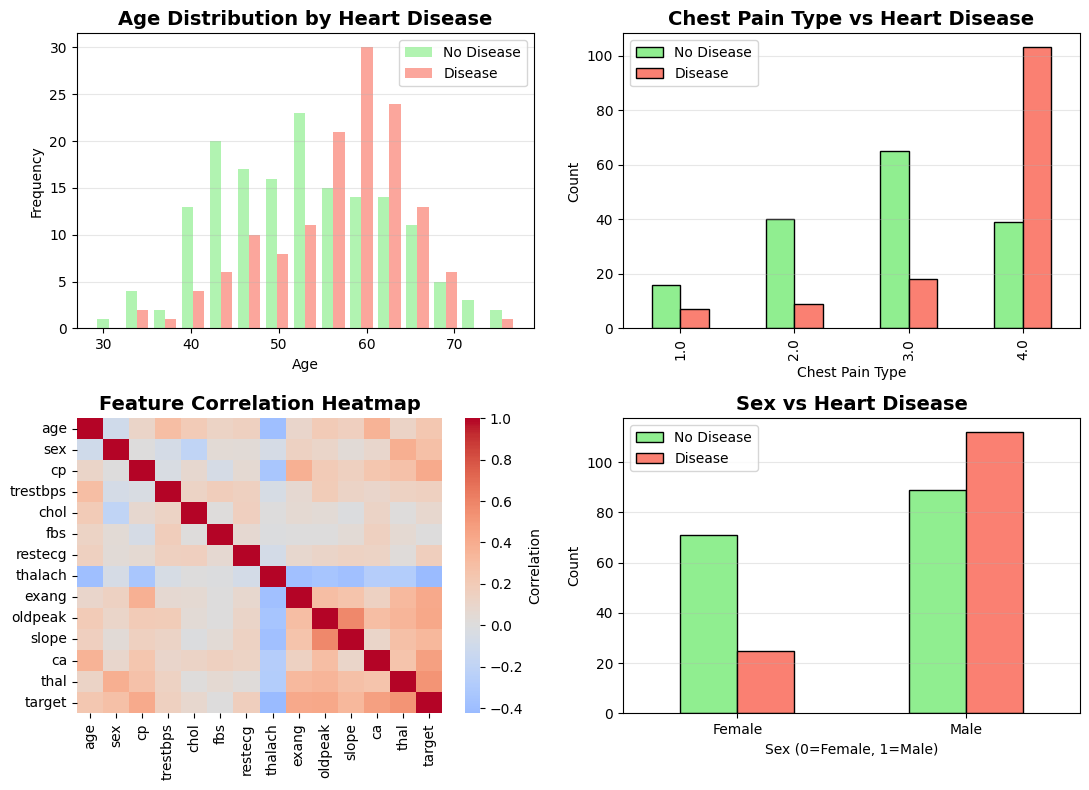

In [8]:
# Visualize the dataset

fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# Age distribution by target
axes[0, 0].hist([df[df['target'] == 0]['age'], df[df['target'] == 1]['age']], 
                label=['No Disease', 'Disease'], bins=15, color=['lightgreen', 'salmon'], alpha=0.7)
axes[0, 0].set_title('Age Distribution by Heart Disease', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Chest pain type distribution
cp_target = pd.crosstab(df['cp'], df['target'])
cp_target.plot(kind='bar', ax=axes[0, 1], color=['lightgreen', 'salmon'], edgecolor='black')
axes[0, 1].set_title('Chest Pain Type vs Heart Disease', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Chest Pain Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(['No Disease', 'Disease'])
axes[0, 1].grid(axis='y', alpha=0.3)

# Correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            ax=axes[1, 0], cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')

# Sex distribution by target
sex_target = pd.crosstab(df['sex'], df['target'])
sex_target.plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], edgecolor='black')
axes[1, 1].set_title('Sex vs Heart Disease', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sex (0=Female, 1=Male)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['No Disease', 'Disease'])
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_xticklabels(['Female', 'Male'], rotation=0)

plt.tight_layout()
plt.show()

## Feature Engineering

In [9]:
# Creating additional features
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100], labels=[0, 1, 2, 3])
df['chol_risk'] = (df['chol'] > 240).astype(int)  # High cholesterol
df['bp_risk'] = (df['trestbps'] > 140).astype(int)  # High blood pressure
df['hr_reserve'] = 220 - df['age'] - df['thalach']  # Heart rate reserve
df['risk_score'] = df['age'] / 10 + df['chol'] / 50 + df['trestbps'] / 20  # Composite risk score

print("\nSample of engineered features:\n")
print(df[['age', 'age_group', 'chol', 'chol_risk', 'hr_reserve', 'risk_score']].head())


Sample of engineered features:

    age age_group   chol  chol_risk  hr_reserve  risk_score
0  63.0         3  233.0          0         7.0       18.21
1  67.0         3  286.0          1        45.0       20.42
2  67.0         3  229.0          0        24.0       17.28
3  37.0         0  250.0          1        -4.0       15.20
4  41.0         1  204.0          0         7.0       14.68


## Preparing Training Data

In [10]:
# Select features for modeling
feature_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal',
                'age_group', 'chol_risk', 'bp_risk', 'hr_reserve', 'risk_score']

X = df[feature_cols]
y = df['target']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())

Training set size: 237 samples
Test set size: 60 samples
Number of features: 18

Class distribution in training set:
target
0    128
1    109
Name: count, dtype: int64


## MLflow Configuration

In [11]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # ROC AUC if probability predictions available
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.0
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_accuracy_mean': cv_mean
    }
    
    print(f"{model_name} Performance:\n")
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  Precision:    {precision:.4f}")
    print(f"  Recall:       {recall:.4f}")
    print(f"  F1-Score:     {f1:.4f}")
    print(f"  ROC-AUC:      {roc_auc:.4f}")
    print(f"  CV Accuracy:  {cv_mean:.4f}")
    
    return metrics, y_pred

print("MLflow experiment configured: heart_disease_classifier")
print("Evaluation function initialized!")

MLflow experiment configured: heart_disease_classifier
Evaluation function initialized!


### Model 1: Logistic Regression

In [12]:
with mlflow.start_run(run_name="LogisticRegression"):
    # Train model
    lr_model = LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='lbfgs',
        max_iter=2000,
        random_state=42
    )
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics, y_pred = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
    
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("C", 0.1)
    mlflow.log_param("penalty", 'l2')
    mlflow.log_param("solver", 'lbfgs')
    mlflow.log_param("n_features", X_train.shape[1])
    
    # Log metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Creating input example
    input_example = np.array([X_train_scaled[0]])
    
    # Log model with input_example to infer signature
    mlflow.sklearn.log_model(lr_model, name="model", input_example=input_example)

Logistic Regression Performance:

  Accuracy:     0.9000
  Precision:    0.9583
  Recall:       0.8214
  F1-Score:     0.8846
  ROC-AUC:      0.9565
  CV Accuracy:  0.8473


### Model 2: Decision Tree

In [13]:
with mlflow.start_run(run_name="DecisionTree"):
    # Train model
    dt_model = DecisionTreeClassifier(
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    dt_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics, y_pred = evaluate_model(
        dt_model, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")
    
    # Log parameters
    mlflow.log_param("model_type", "DecisionTree")
    mlflow.log_param("max_depth", 3)
    mlflow.log_param("min_samples_split", 10)
    mlflow.log_param("min_samples_leaf", 5)
    
    # Log metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Create input example
    input_example = np.array([X_train_scaled[0]])
    
    # Log model with input_example to infer signature
    mlflow.sklearn.log_model(dt_model, name="model", input_example=input_example)

Decision Tree Performance:

  Accuracy:     0.8167
  Precision:    0.8148
  Recall:       0.7857
  F1-Score:     0.8000
  ROC-AUC:      0.8661
  CV Accuracy:  0.7884


### Model 3: Random Forest

In [14]:
with mlflow.start_run(run_name="RandomForest"):
    # Train model
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics, y_pred = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 20)
    mlflow.log_param("min_samples_split", 5)
    
    # Log metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 5 Important Features:")
    print(feature_importance.head())
    
    # Create input example 
    input_example = np.array([X_train_scaled[0]]) 
    
    # Log model with input_example to infer signature
    mlflow.sklearn.log_model(rf_model, name="model", input_example=input_example)

Random Forest Performance:

  Accuracy:     0.8500
  Precision:    0.8800
  Recall:       0.7857
  F1-Score:     0.8302
  ROC-AUC:      0.9408
  CV Accuracy:  0.8180

Top 5 Important Features:
       feature  importance
2           cp    0.139414
12        thal    0.134306
11          ca    0.098276
9      oldpeak    0.089279
17  risk_score    0.078944


### Model 4: Gradient Boosting

In [15]:
with mlflow.start_run(run_name="GradientBoosting"):
    # Train model
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    gb_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics, y_pred = evaluate_model(gb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")
    
    # Log parameters
    mlflow.log_param("model_type", "GradientBoosting")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 3)
    
    # Log metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Create input example
    input_example = np.array([X_train_scaled[0]])
    
    # Log model with input_example to infer signature
    mlflow.sklearn.log_model(gb_model, name="model", input_example=input_example)

Gradient Boosting Performance:

  Accuracy:     0.8167
  Precision:    0.8400
  Recall:       0.7500
  F1-Score:     0.7925
  ROC-AUC:      0.9219
  CV Accuracy:  0.7630


### Model 5: Gaussian Naive Bayes

In [16]:
with mlflow.start_run(run_name="GaussianNB"):
    # Train model
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics, y_pred = evaluate_model(
        nb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gaussian Naive Bayes")
    
    # Log parameters
    mlflow.log_param("model_type", "GaussianNB")
    mlflow.log_param("n_features", X_train.shape[1])
    
    # Log metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Create input example
    input_example = np.array([X_train_scaled[0]])
    
    # Log model with input_example to infer signature
    mlflow.sklearn.log_model(nb_model, name="model", input_example=input_example)

Gaussian Naive Bayes Performance:

  Accuracy:     0.8833
  Precision:    0.8889
  Recall:       0.8571
  F1-Score:     0.8727
  ROC-AUC:      0.9386
  CV Accuracy:  0.8265


## Comprehensive Results Analysis

In [17]:
# Retrieve all experiment runs
experiment = mlflow.get_experiment_by_name("heart_disease_classifier")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Display top models by different metrics
print("Top models by F1-score\n")
top_f1 = runs_df[['tags.mlflow.runName', 'metrics.accuracy', 'metrics.f1_score', 
                   'metrics.roc_auc']].sort_values('metrics.f1_score', ascending=False).head(10)
print(top_f1.to_string(index=False))

print()
print("Top models by ROC-AUC\n")
top_auc = runs_df[['tags.mlflow.runName', 'metrics.accuracy', 'metrics.f1_score', 
                    'metrics.roc_auc']].sort_values('metrics.roc_auc', ascending=False).head(10)
print(top_auc.to_string(index=False))

print(f"\nTotal experiments conducted: {len(runs_df)}")

Top models by F1-score

tags.mlflow.runName  metrics.accuracy  metrics.f1_score  metrics.roc_auc
 LogisticRegression          0.900000          0.884615         0.956473
         GaussianNB          0.883333          0.872727         0.938616
       RandomForest          0.850000          0.830189         0.940848
       DecisionTree          0.816667          0.800000         0.866071
   GradientBoosting          0.816667          0.792453         0.921875

Top models by ROC-AUC

tags.mlflow.runName  metrics.accuracy  metrics.f1_score  metrics.roc_auc
 LogisticRegression          0.900000          0.884615         0.956473
       RandomForest          0.850000          0.830189         0.940848
         GaussianNB          0.883333          0.872727         0.938616
   GradientBoosting          0.816667          0.792453         0.921875
       DecisionTree          0.816667          0.800000         0.866071

Total experiments conducted: 5


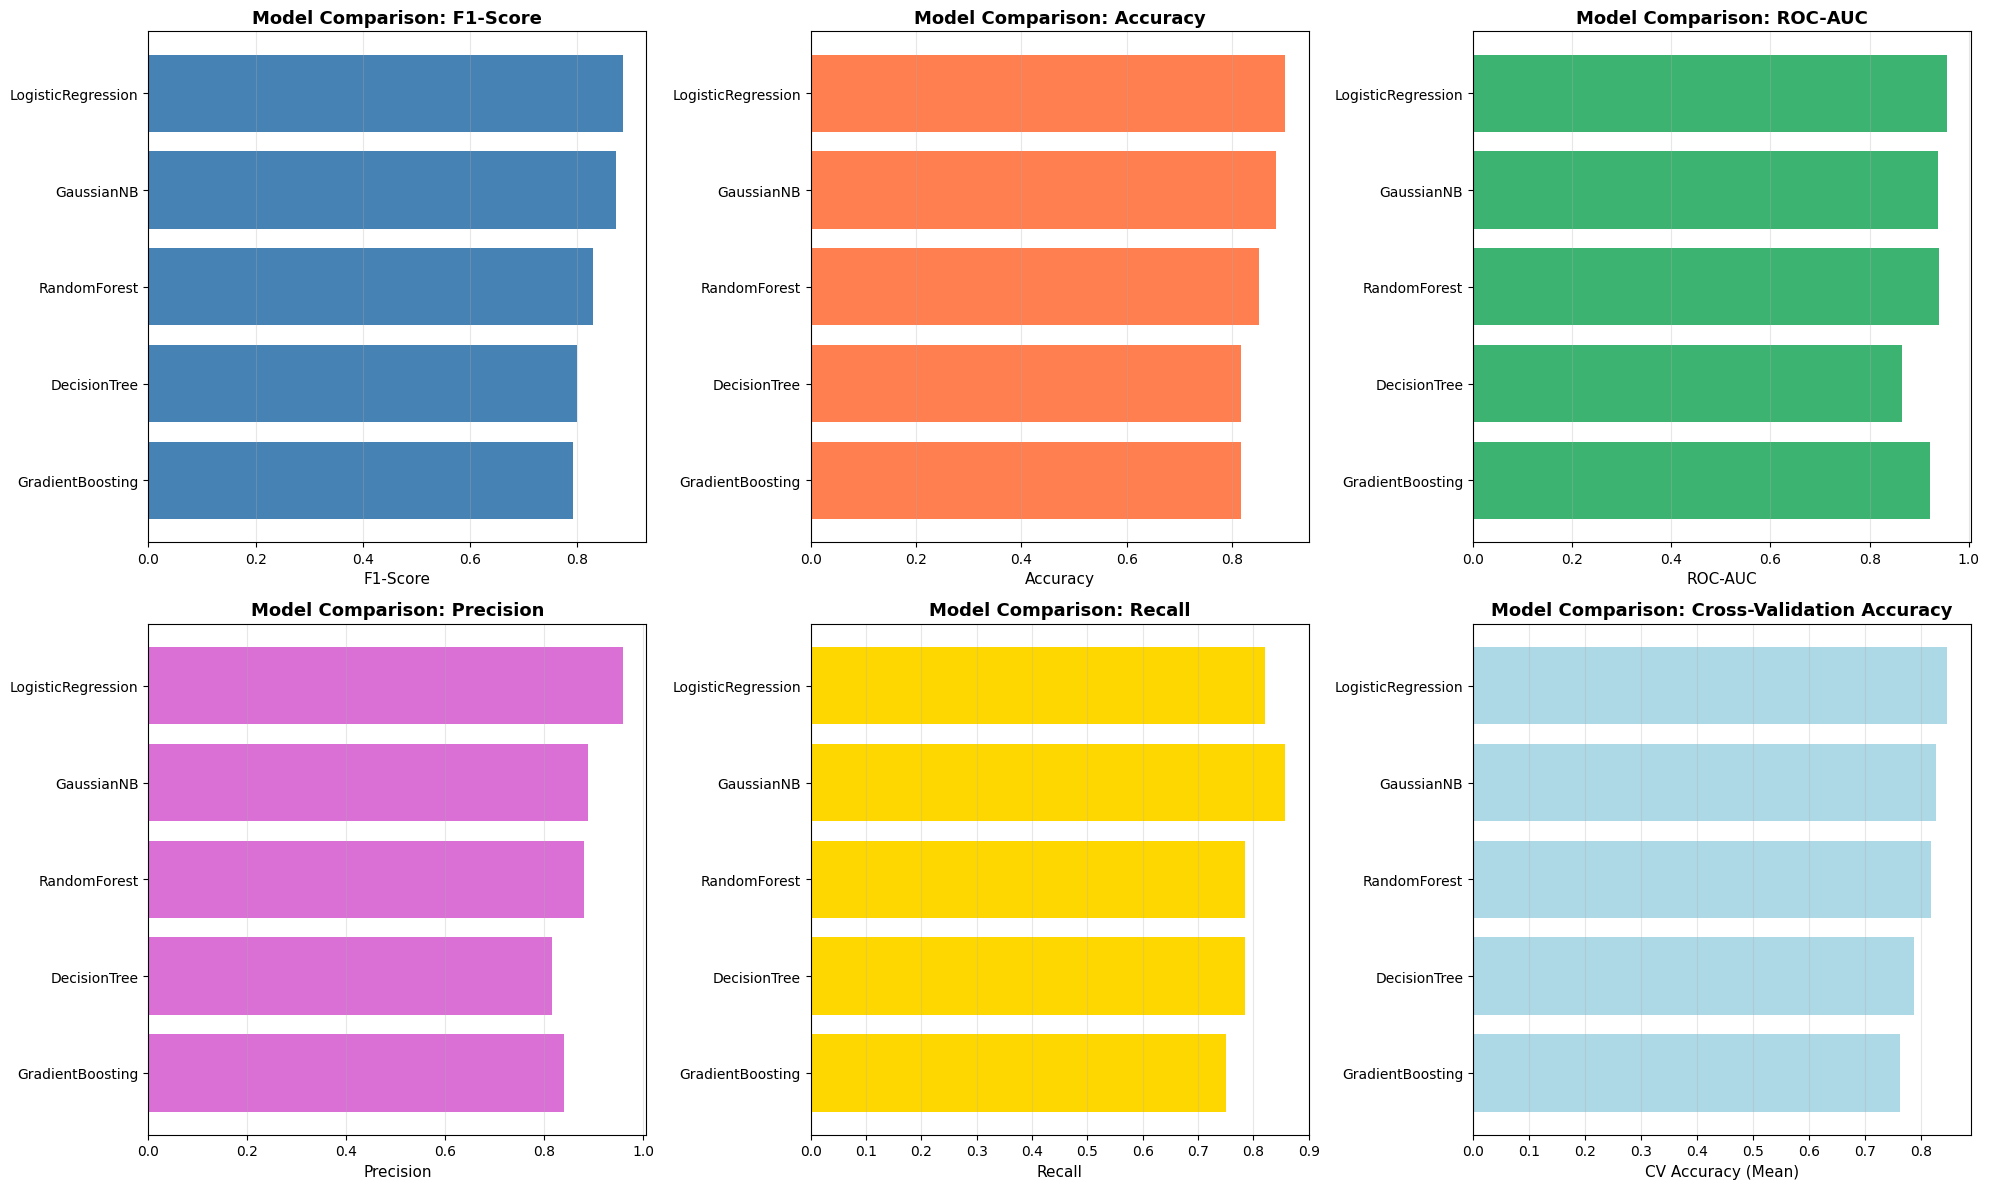

In [18]:
# Visualize comprehensive model comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

runs_sorted = runs_df.sort_values('metrics.f1_score', ascending=True)
top_5 = runs_sorted.tail(15)

# F1-Score comparison
axes[0, 0].barh(top_5['tags.mlflow.runName'], top_5['metrics.f1_score'], color='steelblue')
axes[0, 0].set_xlabel('F1-Score', fontsize=11)
axes[0, 0].set_title('Model Comparison: F1-Score', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Accuracy comparison
axes[0, 1].barh(top_5['tags.mlflow.runName'], top_5['metrics.accuracy'], color='coral')
axes[0, 1].set_xlabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Model Comparison: Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# ROC-AUC comparison
axes[0, 2].barh(top_5['tags.mlflow.runName'], top_5['metrics.roc_auc'], color='mediumseagreen')
axes[0, 2].set_xlabel('ROC-AUC', fontsize=11)
axes[0, 2].set_title('Model Comparison: ROC-AUC', fontsize=13, fontweight='bold')
axes[0, 2].grid(axis='x', alpha=0.3)

# Precision comparison
axes[1, 0].barh(top_5['tags.mlflow.runName'], top_5['metrics.precision'], color='orchid')
axes[1, 0].set_xlabel('Precision', fontsize=11)
axes[1, 0].set_title('Model Comparison: Precision', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Recall comparison
axes[1, 1].barh(top_5['tags.mlflow.runName'], top_5['metrics.recall'], color='gold')
axes[1, 1].set_xlabel('Recall', fontsize=11)
axes[1, 1].set_title('Model Comparison: Recall', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

# CV Accuracy comparison
axes[1, 2].barh(top_5['tags.mlflow.runName'], top_5['metrics.cv_accuracy_mean'], color='lightblue')
axes[1, 2].set_xlabel('CV Accuracy (Mean)', fontsize=11)
axes[1, 2].set_title('Model Comparison: Cross-Validation Accuracy', fontsize=13, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Best Model Selection 

In [19]:
# Find the best run based on F1-Score
best_run = runs_df.loc[runs_df['metrics.f1_score'].idxmax()]

print("Best Model Selected for Deployment:\n")
print(f"Run Name:     {best_run['tags.mlflow.runName']}")
print(f"Model Type:   {best_run['params.model_type']}")
print(f"\nPerformance Metrics:")
print(f"  Accuracy:      {best_run['metrics.accuracy']:.4f}")
print(f"  Precision:     {best_run['metrics.precision']:.4f}")
print(f"  Recall:        {best_run['metrics.recall']:.4f}")
print(f"  F1-Score:      {best_run['metrics.f1_score']:.4f}")
print(f"  ROC-AUC:       {best_run['metrics.roc_auc']:.4f}")
print(f"  CV Accuracy:   {best_run['metrics.cv_accuracy_mean']:.4f}\n")

# Model URI for registration
model_uri = f"runs:/{best_run['run_id']}/model"
model_name = "heart_disease_classifier"

print(f"\nModel URI: {model_uri}")
print(f"Model Name: {model_name}")

Best Model Selected for Deployment:

Run Name:     LogisticRegression
Model Type:   LogisticRegression

Performance Metrics:
  Accuracy:      0.9000
  Precision:     0.9583
  Recall:        0.8214
  F1-Score:      0.8846
  ROC-AUC:       0.9565
  CV Accuracy:   0.8473


Model URI: runs:/06a09bc3c8d94f5885c41af0bdbe88dc/model
Model Name: heart_disease_classifier


## Model Registration in MLflow Model Registry

In [20]:
# Register model
registered_model = mlflow.register_model(model_uri, model_name)
print(f"\nModel registered successfully!")
print(f"  Name:    {model_name}")
print(f"  Version: {registered_model.version}")

2025/11/04 16:51:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/04 16:51:25 INFO mlflow.store.db.utils: Updating database tables
2025-11-04 16:51:25 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-04 16:51:25 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Successfully registered model 'heart_disease_classifier'.
2025/11/04 16:51:25 WARNING mlflow.tracking._model_registry.fluent: Run with id 06a09bc3c8d94f5885c41af0bdbe88dc has no artifacts at artifact path 'model', registering model based on models:/m-4e359efd965a408cbbd035c69cc01f79 instead



Model registered successfully!
  Name:    heart_disease_classifier
  Version: 1


Created version '1' of model 'heart_disease_classifier'.


## Transitioning Model Version to Production

In [21]:
# Wait for registration to complete
import time
time.sleep(5)

# Transition model to Production stage
from mlflow.tracking import MlflowClient
client = MlflowClient()

client.transition_model_version_stage(
        name=model_name,
        version=registered_model.version,
        stage="Production"
    )
print("Successfully Transitioned model to Production stage")

Successfully Transitioned model to Production stage


In [22]:
production_model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f"Production model loaded successfully")

Production model loaded successfully


## Model Inference and Validation

In [23]:
# Load the best model
best_model = mlflow.sklearn.load_model(model_uri)
print("Best model loaded successfully!\n")

# Make predictions on test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Display sample predictions with probabilities
sample_size = 15
comparison_df = pd.DataFrame({
    'Actual': ['Heart Disease' if y == 1 else 'No Disease' for y in y_test.values[:sample_size]],
    'Predicted': ['Heart Disease' if y == 1 else 'No Disease' for y in y_pred[:sample_size]],
    'Probability': [f"{p:.3f}" for p in y_pred_proba[:sample_size]] if y_pred_proba is not None else ['N/A'] * sample_size,
    'Correct': ['✓' if a == p else '✗' for a, p in zip(y_test.values[:sample_size], y_pred[:sample_size])]
}, index=range(1, sample_size + 1))

print(f"Sample Predictions (first {sample_size} test samples):")
print(comparison_df)
print(f"\nCorrect predictions in sample: {(y_test.values[:sample_size] == y_pred[:sample_size]).sum()}/{sample_size}")
print(f"Overall test accuracy: {accuracy_score(y_test, y_pred):.4f}")

Best model loaded successfully!

Sample Predictions (first 15 test samples):
           Actual      Predicted Probability Correct
1      No Disease     No Disease       0.055       ✓
2      No Disease     No Disease       0.164       ✓
3      No Disease     No Disease       0.390       ✓
4      No Disease     No Disease       0.327       ✓
5      No Disease     No Disease       0.445       ✓
6      No Disease     No Disease       0.090       ✓
7   Heart Disease  Heart Disease       0.751       ✓
8      No Disease     No Disease       0.107       ✓
9   Heart Disease     No Disease       0.415       ✗
10     No Disease     No Disease       0.166       ✓
11  Heart Disease  Heart Disease       0.809       ✓
12     No Disease     No Disease       0.077       ✓
13     No Disease     No Disease       0.478       ✓
14  Heart Disease  Heart Disease       0.860       ✓
15  Heart Disease  Heart Disease       0.755       ✓

Correct predictions in sample: 14/15
Overall test accuracy: 0.9000


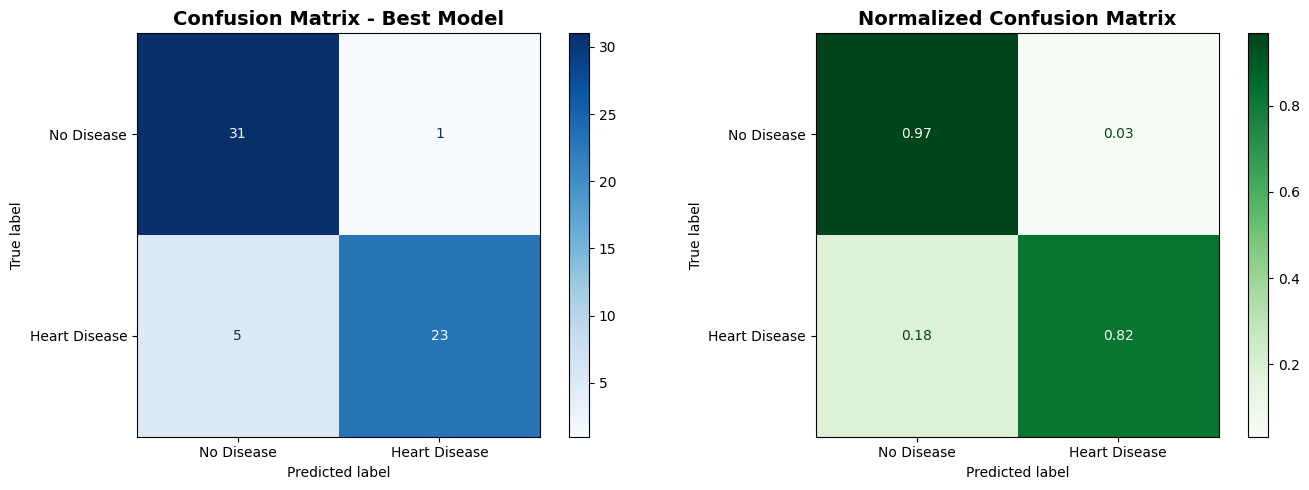


Detailed Classification Report:
               precision    recall  f1-score   support

   No Disease       0.86      0.97      0.91        32
Heart Disease       0.96      0.82      0.88        28

     accuracy                           0.90        60
    macro avg       0.91      0.90      0.90        60
 weighted avg       0.91      0.90      0.90        60



In [24]:
# Generate and visualize confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Heart Disease'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Best Model', fontsize=14, fontweight='bold')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['No Disease', 'Heart Disease'])
disp_norm.plot(ax=axes[1], cmap='Greens', values_format='.2f')
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDetailed Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Heart Disease']))

## Real-Time Inference with the Deployed model

In [25]:
# creating a sample patient data for real-time prediction
sample_patient = {'age': 58, 'sex': 1, 'cp': 3, 'trestbps': 140, 'chol': 250, 'fbs': 1, 'restecg': 0, 
                  'thalach': 145, 'exang': 0, 'oldpeak': 2.5, 'slope': 2, 'ca': 0, 'thal': 7, 'age_group': 2, 
                  'chol_risk': 1, 'bp_risk': 0, 'hr_reserve': 17, 'risk_score': 18.3
                 }

print("Patient Profile:\n")
for feature, value in sample_patient.items():
    print(f"   {feature:15s}: {value}")

# Create DataFrame for prediction
patient_df = pd.DataFrame([sample_patient])

# Make prediction
prediction_prob = production_model.predict(patient_df)[0]
prediction_label = 1 if prediction_prob > 0.5 else 0
diagnosis = "Heart Disease" if prediction_label == 1 else "No Disease"

print("\nPrediction Results:")
print(f"   Diagnosis:     {diagnosis}")

Patient Profile:

   age            : 58
   sex            : 1
   cp             : 3
   trestbps       : 140
   chol           : 250
   fbs            : 1
   restecg        : 0
   thalach        : 145
   exang          : 0
   oldpeak        : 2.5
   slope          : 2
   ca             : 0
   thal           : 7
   age_group      : 2
   chol_risk      : 1
   bp_risk        : 0
   hr_reserve     : 17
   risk_score     : 18.3

Prediction Results:
   Diagnosis:     Heart Disease


In [37]:
import requests
import json
import pandas as pd

# Endpoint URL
url = 'http://127.0.0.1:5001//invocations'

# Prepare sample data
sample_data = {
    "dataframe_split": {
        "columns": ["age", "sex", "cp", "trestbps", "chol", "fbs",
                   "restecg", "thalach", "exang", "oldpeak", "slope",
                   "ca", "thal", "age_group", "chol_risk", "bp_risk",
                   "hr_reserve", "risk_score"],
        "data": [[58, 1, 3, 140, 250, 1, 0, 145, 0, 2.5, 2, 0, 7,
                 2, 1, 0, 17, 18.3]]
    }
}

# Make prediction request
response = requests.post(url, json=sample_data)

# Parse response
if response.status_code == 200:
    predictions = response.json()
    prediction_prob = production_model.predict(patient_df)[0]
    prediction_label = 1 if prediction_prob > 0.5 else 0
    diagnosis = "Heart Disease" if prediction_label == 1 else "No Disease"
    print("Diagnosis:", diagnosis)
    print("Prediction:", predictions)
else:
    print("Error:", response.status_code, response.text)

Diagnosis: Heart Disease
Prediction: {'predictions': [1]}


In [35]:
client_code = '''import requests
import json
import pandas as pd

# Endpoint URL (adjust port if needed)
url = 'http://127.0.0.1:5001/invocations'

# Prepare sample data
sample_data = {
    "dataframe_split": {
        "columns": ["age", "sex", "cp", "trestbps", "chol", "fbs",
                   "restecg", "thalach", "exang", "oldpeak", "slope",
                   "ca", "thal", "age_group", "chol_risk", "bp_risk",
                   "hr_reserve", "risk_score"],
        "data": [[58, 1, 3, 140, 250, 1, 0, 145, 0, 2.5, 2, 0, 7,
                 2, 1, 0, 17, 18.3]]
    }
}

# Make prediction request
response = requests.post(url, json=sample_data)

# Parse response
if response.status_code == 200:
    predictions = response.json()
    print("Prediction:", predictions)
else:
    print("Error:", response.status_code, response.text)
'''

with open('model_client.py', 'w') as f:
    f.write(client_code)

print("Created client script: model_client.py")
print("After starting model server - Run: python3 model_client.py")

Created client script: model_client.py
After starting model server - Run: python3 model_client.py
